# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
from yolov3.models import Darknet

#model_4classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [3]:
#nparams = sum(p.numel() for p in model_4classes.parameters())
#print (f"{nparams:,}")

In [4]:
bs = 8
nepochs = 50
ncpu = 6
gradient_accumulations = 4
evaluation_interval = 2
checkpoint_interval = 10
img_size = 416

In [5]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate, evaluate_depth

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/iros2021-rgbd.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
#model = Darknet("yolov3/config/iros2021-rgbd.cfg").to(device)#, img_size=img_size).to(device)
model = Darknet("yolov3/config/iros2021-tiny-rgbd.cfg").to(device)#, img_size=img_size).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint





/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

['ring0', 'ring1', 'ring2', 'ring3']


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [6]:
#model.load_state_dict(torch.load("/home/jose/ros_ws/src/gr_perception/gr_ml/nb/testingyolo/checkpoints/yolov3_v2_ckpt_140.pth"))

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/yolo_rgbd')
plot_interval = 100

In [8]:
# Get dataloader
dataset = MyListDataset(train_path, augment=True, multiscale=True)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("depth_testingyolo")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    epoch_loss = 0.0

    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)0
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()
        
        epoch_loss += outputs.shape[0] * loss.item()

        writer.add_scalar('Loss/train_batch', loss,(epoch*len(dataloader)+batch_i))

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------
        yololoss = [yolo.metrics["loss"] for yolo in model.yolo_layers]
        for i, yloss in enumerate(yololoss):
            writer.add_scalar('Loss/yolo_loss'+str(i), yloss,(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss1', yololoss[1],(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss2', yololoss[2],(epoch*len(dataloader)+batch_i))

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        if batch_i % plot_interval == 0:
            # Log metrics at each YOLO layer
            for i, metric in enumerate(metrics):
                formats = {m: "%.6f" for m in metrics}
                formats["grid_size"] = "%2d"
                formats["cls_acc"] = "%.2f%%"
                row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
                metric_table += [[metric, *row_metrics]]

                # Tensorboard logging
                """
                tensorboard_log = []
                for j, yolo in enumerate(model.yolo_layers):
                    for name, metric in yolo.metrics.items():
                        if name != "grid_size":
                            tensorboard_log += [(f"{name}_{j+1}", metric)]
                tensorboard_log += [("loss", loss.item())]
                """
                #logger.list_of_scalars_summary(tensorboard_log, batches_done)

            log_str += AsciiTable(metric_table).table
            log_str += f"\nTotal loss {loss.item()}"

            # Determine approximate time left for epoch
            epoch_batches_left = len(dataloader) - (batch_i + 1)
            time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
            log_str += f"\n---- ETA {time_left}"

            print(log_str)
            #break

        model.seen += imgs.size(0)
    
    
    writer.add_scalar('Loss/train_epoch', epoch_loss / len(dataloader), epoch)
    #print ("HERE", len(dataloader), epoch_loss)


    if epoch % evaluation_interval == 0:
        print(log_str)
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        eval_results = evaluate_depth(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=1,
        )
        
        if eval_results is not None:
            precision, recall, AP, f1, ap_class = eval_results
            """
            evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
            logger.list_of_scalars_summary(evaluation_metrics, epoch)
            """
            # Print class APs and mAP
            ap_table = [["Index", "Class name", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
            print(f"---- mAP {AP.mean()}")
            writer.add_scalar('metrics/map_eval', AP.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/precision', precision.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/recall', recall.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/f1', f1.mean(), int(epoch / evaluation_interval))


    if epoch % checkpoint_interval == 0:
        print (log_str)
        torch.save(model.state_dict(), f"depth_testingyolo/checkpoints/rgbd_yolov3_v2_ckpt_%d.pth" % epoch)


994
1000

---- [Epoch 0/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 84.593269    | 70.299911    |
| x          | 0.089532     | 0.087697     |
| y          | 0.227663     | 0.276535     |
| w          | 2.957048     | 0.625848     |
| h          | 1.411846     | 0.934368     |
| conf       | 79.021973    | 67.687881    |
| cls        | 0.885209     | 0.687583     |
| cls_acc    | 25.00%       | 62.50%       |
| recall50   | 0.000000     | 0.125000     |
| recall75   | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000305     |
| conf_obj   | 0.578471     | 0.534615     |
| conf_noobj | 0.536965     | 0.485805     |
+------------+--------------+--------------+
Total loss 154.8931884765625
---- ETA 0:10:07.734941

---- [Epoch 0/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 0/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 390.01it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.00000 |
| 1     | ring1      | 0.32540 |
| 2     | ring2      | 0.04000 |
| 3     | ring3      | 0.39043 |
+-------+------------+---------+
---- mAP 0.18895625240328642

---- [Epoch 0/50, Batch 124/125] ----




---- [Epoch 1/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 1.935742     | 2.262381     |
| x          | 0.062684     | 0.057182     |
| y          | 0.023316     | 0.008326     |
| w          | 0.056058     | 0.050573     |
| h          | 0.049878     | 0.023198     |
| conf       | 1.414936     | 1.691339     |
| cls        | 0.328871     | 0.431761     |
| cls_acc    | 62.50%       | 50.00%       |
| recall50   | 0.375000     | 0.500000     |
| recall75   | 0.000000     | 0.250000     |
| precision  | 0.300000     | 0.148148     |
| conf_obj   | 0.556241     | 0.698189     |
| conf_noobj | 0.006997     | 0.012123     |
+------------+--------------+--------------+
Total loss 4.198122978210449
---- ETA 0:05:48.248921

---- [Epoch 1/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | Y

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 2/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 724.59it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.00000 |
| 1     | ring1      | 0.00617 |
| 2     | ring2      | 0.16078 |
| 3     | ring3      | 0.58682 |
+-------+------------+---------+
---- mAP 0.18844337733428823



---- [Epoch 3/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 1.732218     | 1.694980     |
| x          | 0.130444     | 0.070230     |
| y          | 0.006156     | 0.004281     |
| w          | 0.057695     | 0.016730     |
| h          | 0.057362     | 0.009874     |
| conf       | 1.197625     | 1.302620     |
| cls        | 0.282935     | 0.291245     |
| cls_acc    | 87.50%       | 87.50%       |
| recall50   | 0.500000     | 0.375000     |
| recall75   | 0.375000     | 0.375000     |
| precision  | 0.363636     | 0.073171     |
| conf_obj   | 0.613451     | 0.614775     |
| conf_noobj | 0.003794     | 0.005129     |
+------------+--------------+--------------+
Total loss 3.4271984100341797
---- ETA 0:05:55.917118

---- [Epoch 3/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 4/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 450.00it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.69108 |
| 2     | ring2      | 0.25614 |
| 3     | ring3      | 0.52519 |
+-------+------------+---------+
---- mAP 0.4181000151965646



---- [Epoch 5/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 1.473805     | 1.376616     |
| x          | 0.052445     | 0.051071     |
| y          | 0.000996     | 0.001595     |
| w          | 0.072089     | 0.059069     |
| h          | 0.064969     | 0.022715     |
| conf       | 1.054701     | 1.000024     |
| cls        | 0.228605     | 0.242143     |
| cls_acc    | 100.00%      | 75.00%       |
| recall50   | 0.875000     | 0.625000     |
| recall75   | 0.625000     | 0.500000     |
| precision  | 0.777778     | 0.217391     |
| conf_obj   | 0.746656     | 0.735951     |
| conf_noobj | 0.003250     | 0.003737     |
+------------+--------------+--------------+
Total loss 2.8504209518432617
---- ETA 0:05:18.798129

---- [Epoch 5/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 6/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 681.47it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.44907 |
| 2     | ring2      | 0.32924 |
| 3     | ring3      | 0.66488 |
+-------+------------+---------+
---- mAP 0.41079941264844944



---- [Epoch 7/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.788239     | 0.946669     |
| x          | 0.020921     | 0.019902     |
| y          | 0.013799     | 0.002111     |
| w          | 0.027507     | 0.039960     |
| h          | 0.034254     | 0.039760     |
| conf       | 0.462880     | 0.702682     |
| cls        | 0.228877     | 0.142255     |
| cls_acc    | 75.00%       | 75.00%       |
| recall50   | 0.750000     | 0.625000     |
| recall75   | 0.625000     | 0.500000     |
| precision  | 0.428571     | 0.125000     |
| conf_obj   | 0.902918     | 0.819015     |
| conf_noobj | 0.002356     | 0.002938     |
+------------+--------------+--------------+
Total loss 1.7349077463150024
---- ETA 0:05:30.138606

---- [Epoch 7/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 8/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 704.21it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.26667 |
| 1     | ring1      | 0.41053 |
| 2     | ring2      | 0.40345 |
| 3     | ring3      | 0.59666 |
+-------+------------+---------+
---- mAP 0.41932876858135804



---- [Epoch 9/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 1.227463     | 1.332427     |
| x          | 0.116790     | 0.074456     |
| y          | 0.038736     | 0.018999     |
| w          | 0.056586     | 0.069544     |
| h          | 0.047224     | 0.069342     |
| conf       | 0.804340     | 0.881675     |
| cls        | 0.163787     | 0.218412     |
| cls_acc    | 100.00%      | 75.00%       |
| recall50   | 0.750000     | 0.500000     |
| recall75   | 0.500000     | 0.375000     |
| precision  | 0.333333     | 0.076923     |
| conf_obj   | 0.772344     | 0.738294     |
| conf_noobj | 0.003381     | 0.003411     |
+------------+--------------+--------------+
Total loss 2.5598902702331543
---- ETA 0:05:48.572351

---- [Epoch 9/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 10/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 721.26it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.40000 |
| 1     | ring1      | 0.37650 |
| 2     | ring2      | 0.39298 |
| 3     | ring3      | 0.40756 |
+-------+------------+---------+
---- mAP 0.3942599435875978

---- [Epoch 10/50, Batch 124/125] ----




---- [Epoch 11/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 1.115753     | 1.197203     |
| x          | 0.070424     | 0.033552     |
| y          | 0.023682     | 0.008823     |
| w          | 0.096747     | 0.031690     |
| h          | 0.088020     | 0.025809     |
| conf       | 0.302287     | 0.666045     |
| cls        | 0.534594     | 0.431284     |
| cls_acc    | 62.50%       | 75.00%       |
| recall50   | 0.500000     | 0.625000     |
| recall75   | 0.000000     | 0.500000     |
| precision  | 0.333333     | 0.131579     |
| conf_obj   | 0.931219     | 0.833183     |
| conf_noobj | 0.001780     | 0.002320     |
+------------+--------------+--------------+
Total loss 2.312955856323242
---- ETA 0:06:01.688317

---- [Epoch 11/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 12/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 747.25it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.40000 |
| 1     | ring1      | 0.47802 |
| 2     | ring2      | 0.35154 |
| 3     | ring3      | 0.53649 |
+-------+------------+---------+
---- mAP 0.4415120343866355



---- [Epoch 13/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 1.723740     | 1.608777     |
| x          | 0.026316     | 0.050745     |
| y          | 0.050263     | 0.000585     |
| w          | 0.031651     | 0.018804     |
| h          | 0.034030     | 0.013167     |
| conf       | 1.308616     | 1.271313     |
| cls        | 0.272863     | 0.254163     |
| cls_acc    | 62.50%       | 75.00%       |
| recall50   | 0.500000     | 0.625000     |
| recall75   | 0.250000     | 0.375000     |
| precision  | 0.400000     | 0.185185     |
| conf_obj   | 0.661591     | 0.615169     |
| conf_noobj | 0.002403     | 0.003070     |
+------------+--------------+--------------+
Total loss 3.3325161933898926
---- ETA 0:05:32.763260

---- [Epoch 13/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 14/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 773.54it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.24319 |
| 2     | ring2      | 0.25090 |
| 3     | ring3      | 0.68894 |
+-------+------------+---------+
---- mAP 0.34575715422232733



---- [Epoch 15/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.983855     | 0.990075     |
| x          | 0.084964     | 0.114880     |
| y          | 0.000985     | 0.004663     |
| w          | 0.027747     | 0.019372     |
| h          | 0.078296     | 0.049844     |
| conf       | 0.499943     | 0.513180     |
| cls        | 0.291919     | 0.288136     |
| cls_acc    | 75.00%       | 75.00%       |
| recall50   | 0.625000     | 0.625000     |
| recall75   | 0.125000     | 0.250000     |
| precision  | 0.294118     | 0.147059     |
| conf_obj   | 0.888669     | 0.878876     |
| conf_noobj | 0.002802     | 0.002639     |
+------------+--------------+--------------+
Total loss 1.9739294052124023
---- ETA 0:05:15.694244

---- [Epoch 15/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 16/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 800.02it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.33333 |
| 1     | ring1      | 0.50924 |
| 2     | ring2      | 0.45498 |
| 3     | ring3      | 0.64497 |
+-------+------------+---------+
---- mAP 0.4856315118724186



---- [Epoch 17/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.953293     | 1.118412     |
| x          | 0.026849     | 0.048259     |
| y          | 0.002410     | 0.000745     |
| w          | 0.008609     | 0.016641     |
| h          | 0.021767     | 0.011295     |
| conf       | 0.625965     | 0.782504     |
| cls        | 0.267692     | 0.258968     |
| cls_acc    | 75.00%       | 62.50%       |
| recall50   | 0.625000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     |
| precision  | 0.454545     | 0.166667     |
| conf_obj   | 0.825010     | 0.798453     |
| conf_noobj | 0.002644     | 0.003064     |
+------------+--------------+--------------+
Total loss 2.071704626083374
---- ETA 0:05:24.447318

---- [Epoch 17/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 18/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 623.87it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.26667 |
| 1     | ring1      | 0.49270 |
| 2     | ring2      | 0.38987 |
| 3     | ring3      | 0.60122 |
+-------+------------+---------+
---- mAP 0.4376155951126498



---- [Epoch 19/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.046197     | 0.973865     |
| x          | 0.014972     | 0.054338     |
| y          | 0.009813     | 0.002357     |
| w          | 0.051698     | 0.017714     |
| h          | 0.073361     | 0.017075     |
| conf       | 0.606650     | 0.642700     |
| cls        | 0.289703     | 0.239681     |
| cls_acc    | 75.00%       | 87.50%       |
| recall50   | 0.625000     | 0.750000     |
| recall75   | 0.500000     | 0.625000     |
| precision  | 0.454545     | 0.181818     |
| conf_obj   | 0.801195     | 0.777638     |
| conf_noobj | 0.001821     | 0.001910     |
+------------+--------------+--------------+
Total loss 2.02006196975708
---- ETA 0:04:56.024788

---- [Epoch 19/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 20/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 1130.77it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.52000 |
| 1     | ring1      | 0.47361 |
| 2     | ring2      | 0.53887 |
| 3     | ring3      | 0.67938 |
+-------+------------+---------+
---- mAP 0.5529635390088741

---- [Epoch 20/50, Batch 124/125] ----


---- [Epoch 21/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 2.174244     | 1.673510     |
| x          | 0.143049     | 0.080491     |
| y          | 0.000559     | 0.000940     |
| w          | 0.033813     | 0.022342     |
| h          | 0.030701     | 0.025308     |
| conf       | 1.640835     | 1.173321     |
| cls        | 0.325288     | 0.371108     |
| cls_acc    | 75.00%       | 75.00%       |
| recall50   | 0.375000     | 0.500000     |
| recall75   | 0.250000     | 0.375000     |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 22/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 795.96it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.41040 |
| 2     | ring2      | 0.50223 |
| 3     | ring3      | 0.66270 |
+-------+------------+---------+
---- mAP 0.44383267741789934



---- [Epoch 23/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.466683     | 0.777266     |
| x          | 0.060957     | 0.049423     |
| y          | 0.004784     | 0.000458     |
| w          | 0.015100     | 0.025020     |
| h          | 0.008500     | 0.009703     |
| conf       | 0.353672     | 0.676897     |
| cls        | 0.023669     | 0.015764     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.875000     | 0.875000     |
| recall75   | 0.625000     | 0.750000     |
| precision  | 0.875000     | 0.225806     |
| conf_obj   | 0.895291     | 0.783792     |
| conf_noobj | 0.001837     | 0.002538     |
+------------+--------------+--------------+
Total loss 1.2439491748809814
---- ETA 0:04:56.747241

---- [Epoch 23/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 24/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 805.98it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.34921 |
| 2     | ring2      | 0.37534 |
| 3     | ring3      | 0.35585 |
+-------+------------+---------+
---- mAP 0.3201003891920853



---- [Epoch 25/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 2.133723     | 1.596180     |
| x          | 0.112892     | 0.067213     |
| y          | 0.003140     | 0.004673     |
| w          | 0.030753     | 0.182916     |
| h          | 0.060130     | 0.120028     |
| conf       | 1.796353     | 1.064266     |
| cls        | 0.130455     | 0.157084     |
| cls_acc    | 87.50%       | 87.50%       |
| recall50   | 0.500000     | 0.500000     |
| recall75   | 0.250000     | 0.125000     |
| precision  | 0.363636     | 0.129032     |
| conf_obj   | 0.511024     | 0.578222     |
| conf_noobj | 0.003463     | 0.002221     |
+------------+--------------+--------------+
Total loss 3.729903221130371
---- ETA 0:05:00.022892

---- [Epoch 25/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 26/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 790.15it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.53704 |
| 2     | ring2      | 0.52782 |
| 3     | ring3      | 0.66952 |
+-------+------------+---------+
---- mAP 0.4835960266581937



---- [Epoch 27/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.720165     | 0.565596     |
| x          | 0.017948     | 0.034129     |
| y          | 0.000895     | 0.000410     |
| w          | 0.009721     | 0.008761     |
| h          | 0.011144     | 0.007154     |
| conf       | 0.652393     | 0.490547     |
| cls        | 0.028064     | 0.024595     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.875000     | 1.000000     |
| recall75   | 0.750000     | 0.875000     |
| precision  | 0.700000     | 0.320000     |
| conf_obj   | 0.773790     | 0.864937     |
| conf_noobj | 0.002772     | 0.002461     |
+------------+--------------+--------------+
Total loss 1.2857601642608643
---- ETA 0:05:42.153761

---- [Epoch 27/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 28/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 887.07it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.52000 |
| 1     | ring1      | 0.40086 |
| 2     | ring2      | 0.38930 |
| 3     | ring3      | 0.71182 |
+-------+------------+---------+
---- mAP 0.5054949802523817



---- [Epoch 29/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 1.339140     | 1.143646     |
| x          | 0.037870     | 0.050071     |
| y          | 0.000902     | 0.016889     |
| w          | 0.075011     | 0.040992     |
| h          | 0.051370     | 0.013164     |
| conf       | 1.108541     | 0.959389     |
| cls        | 0.065446     | 0.063141     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 0.875000     |
| recall75   | 0.500000     | 0.500000     |
| precision  | 0.461538     | 0.179487     |
| conf_obj   | 0.639510     | 0.774177     |
| conf_noobj | 0.003084     | 0.003285     |
+------------+--------------+--------------+
Total loss 2.482785940170288
---- ETA 0:05:20.229229

---- [Epoch 29/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 30/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 721.48it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.00000 |
| 1     | ring1      | 0.41653 |
| 2     | ring2      | 0.36832 |
| 3     | ring3      | 0.58987 |
+-------+------------+---------+
---- mAP 0.3436825386757345

---- [Epoch 30/50, Batch 124/125] ----


---- [Epoch 31/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.343619     | 0.768133     |
| x          | 0.025847     | 0.005079     |
| y          | 0.007306     | 0.006064     |
| w          | 0.005511     | 0.009923     |
| h          | 0.008024     | 0.023993     |
| conf       | 0.265766     | 0.702141     |
| cls        | 0.031164     | 0.020934     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.875000     |
| recall75   | 0.875000     | 0.750000     |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 32/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 742.32it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.55000 |
| 1     | ring1      | 0.41948 |
| 2     | ring2      | 0.38482 |
| 3     | ring3      | 0.61962 |
+-------+------------+---------+
---- mAP 0.49348176862723236



---- [Epoch 33/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 1.486288     | 1.381324     |
| x          | 0.027714     | 0.040796     |
| y          | 0.009080     | 0.003039     |
| w          | 0.020192     | 0.038905     |
| h          | 0.034307     | 0.036917     |
| conf       | 1.235879     | 1.170307     |
| cls        | 0.159115     | 0.091360     |
| cls_acc    | 87.50%       | 100.00%      |
| recall50   | 0.500000     | 0.625000     |
| recall75   | 0.250000     | 0.500000     |
| precision  | 0.400000     | 0.238095     |
| conf_obj   | 0.603793     | 0.586777     |
| conf_noobj | 0.002792     | 0.002627     |
+------------+--------------+--------------+
Total loss 2.867611885070801
---- ETA 0:05:10.907405

---- [Epoch 33/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 34/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 734.88it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.52000 |
| 1     | ring1      | 0.40829 |
| 2     | ring2      | 0.49184 |
| 3     | ring3      | 0.70674 |
+-------+------------+---------+
---- mAP 0.5317171777265298

---- [Epoch 35/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.831815     | 0.942126     |
| x          | 0.016745     | 0.014241     |
| y          | 0.005878     | 0.015396     |
| w          | 0.010825     | 0.013631     |
| h          | 0.019864     | 0.010263     |
| conf       | 0.615583     | 0.823635     |
| cls        | 0.162920     | 0.064960     |
| cls_acc    | 75.00%       | 100.00%      |
| recall50   | 0.750000     | 0.750000     |
| recall75   | 0.750000     | 0.750000     |
| precision  | 0.666667     | 0.222222  

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 36/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 743.80it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.40000 |
| 1     | ring1      | 0.46936 |
| 2     | ring2      | 0.43647 |
| 3     | ring3      | 0.67683 |
+-------+------------+---------+
---- mAP 0.4956639747605054



---- [Epoch 37/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.789809     | 0.571636     |
| x          | 0.008100     | 0.016241     |
| y          | 0.001408     | 0.004223     |
| w          | 0.008581     | 0.008617     |
| h          | 0.013343     | 0.012919     |
| conf       | 0.692472     | 0.476459     |
| cls        | 0.065906     | 0.053177     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.875000     | 1.000000     |
| recall75   | 0.875000     | 1.000000     |
| precision  | 0.636364     | 0.266667     |
| conf_obj   | 0.771277     | 0.865172     |
| conf_noobj | 0.002644     | 0.002110     |
+------------+--------------+--------------+
Total loss 1.3614449501037598
---- ETA 0:05:49.398336

---- [Epoch 37/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 38/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 771.22it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.33333 |
| 1     | ring1      | 0.49791 |
| 2     | ring2      | 0.38493 |
| 3     | ring3      | 0.61708 |
+-------+------------+---------+
---- mAP 0.4583129256625377



---- [Epoch 39/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.411105     | 0.533772     |
| x          | 0.010583     | 0.008754     |
| y          | 0.002306     | 0.004834     |
| w          | 0.007868     | 0.004275     |
| h          | 0.009842     | 0.006130     |
| conf       | 0.325118     | 0.453818     |
| cls        | 0.055388     | 0.055961     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.666667     | 0.242424     |
| conf_obj   | 0.928684     | 0.905878     |
| conf_noobj | 0.001621     | 0.002284     |
+------------+--------------+--------------+
Total loss 0.9448767900466919
---- ETA 0:05:24.037001

---- [Epoch 39/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 40/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 1146.61it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.20000 |
| 1     | ring1      | 0.38889 |
| 2     | ring2      | 0.49137 |
| 3     | ring3      | 0.62007 |
+-------+------------+---------+
---- mAP 0.42508172481914686

---- [Epoch 40/50, Batch 124/125] ----


---- [Epoch 41/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.098678     | 0.763515     |
| x          | 0.018867     | 0.022429     |
| y          | 0.003821     | 0.010101     |
| w          | 0.031282     | 0.018577     |
| h          | 0.022052     | 0.004187     |
| conf       | 0.905629     | 0.633753     |
| cls        | 0.117027     | 0.074467     |
| cls_acc    | 87.50%       | 87.50%       |
| recall50   | 0.875000     | 0.875000     |
| recall75   | 0.875000     | 0.875000     

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 42/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 809.09it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.40000 |
| 1     | ring1      | 0.46561 |
| 2     | ring2      | 0.18303 |
| 3     | ring3      | 0.55896 |
+-------+------------+---------+
---- mAP 0.40189872166217927



---- [Epoch 43/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.466767     | 0.612858     |
| x          | 0.051520     | 0.019420     |
| y          | 0.006381     | 0.012264     |
| w          | 0.026067     | 0.010714     |
| h          | 0.018536     | 0.011104     |
| conf       | 0.300582     | 0.497650     |
| cls        | 0.063680     | 0.061705     |
| cls_acc    | 87.50%       | 87.50%       |
| recall50   | 0.875000     | 0.875000     |
| recall75   | 0.375000     | 0.875000     |
| precision  | 0.700000     | 0.166667     |
| conf_obj   | 0.922274     | 0.897785     |
| conf_noobj | 0.001677     | 0.002345     |
+------------+--------------+--------------+
Total loss 1.0796245336532593
---- ETA 0:06:12.840472

---- [Epoch 43/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 44/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 786.59it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.33333 |
| 1     | ring1      | 0.50703 |
| 2     | ring2      | 0.41765 |
| 3     | ring3      | 0.71352 |
+-------+------------+---------+
---- mAP 0.49288375354630165



---- [Epoch 45/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.809763     | 0.877389     |
| x          | 0.062773     | 0.062541     |
| y          | 0.004077     | 0.005309     |
| w          | 0.024724     | 0.019721     |
| h          | 0.021353     | 0.009676     |
| conf       | 0.641027     | 0.720632     |
| cls        | 0.055809     | 0.059511     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 0.875000     |
| recall75   | 0.500000     | 0.625000     |
| precision  | 0.545455     | 0.189189     |
| conf_obj   | 0.830658     | 0.785235     |
| conf_noobj | 0.001443     | 0.002310     |
+------------+--------------+--------------+
Total loss 1.68715238571167
---- ETA 0:05:02.505787

---- [Epoch 45/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 46/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 622.85it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.55000 |
| 1     | ring1      | 0.31296 |
| 2     | ring2      | 0.44014 |
| 3     | ring3      | 0.61153 |
+-------+------------+---------+
---- mAP 0.47865864830005855



---- [Epoch 47/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.167504     | 1.201876     |
| x          | 0.029386     | 0.061603     |
| y          | 0.001433     | 0.001229     |
| w          | 0.009806     | 0.021355     |
| h          | 0.008849     | 0.024640     |
| conf       | 0.889332     | 0.948351     |
| cls        | 0.228697     | 0.144698     |
| cls_acc    | 87.50%       | 87.50%       |
| recall50   | 0.750000     | 0.625000     |
| recall75   | 0.625000     | 0.500000     |
| precision  | 0.545455     | 0.238095     |
| conf_obj   | 0.709957     | 0.646481     |
| conf_noobj | 0.001624     | 0.001698     |
+------------+--------------+--------------+
Total loss 2.369379997253418
---- ETA 0:05:07.641540

---- [Epoch 47/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    |

Detecting objects:   0%|          | 0/100 [00:00<?, ?it/s]


---- [Epoch 48/50, Batch 124/125] ----


---- Evaluating Model ----
100
100


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 689.37it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.40000 |
| 1     | ring1      | 0.35825 |
| 2     | ring2      | 0.34331 |
| 3     | ring3      | 0.47679 |
+-------+------------+---------+
---- mAP 0.39458754818322217



---- [Epoch 49/50, Batch 0/125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.996667     | 0.756787     |
| x          | 0.108469     | 0.035307     |
| y          | 0.010422     | 0.009793     |
| w          | 0.022428     | 0.025480     |
| h          | 0.009893     | 0.018687     |
| conf       | 0.777523     | 0.540657     |
| cls        | 0.067932     | 0.126861     |
| cls_acc    | 100.00%      | 87.50%       |
| recall50   | 0.625000     | 0.875000     |
| recall75   | 0.625000     | 0.625000     |
| precision  | 0.384615     | 0.200000     |
| conf_obj   | 0.754816     | 0.851606     |
| conf_noobj | 0.002901     | 0.002393     |
+------------+--------------+--------------+
Total loss 1.7534531354904175
---- ETA 0:05:24.489949

---- [Epoch 49/50, Batch 100/125] ----
+------------+--------------+--------------+
| Metrics    

In [9]:
def get_image_iteration(myiter):
    return next(myiter)

In [10]:
labels=[]

In [11]:
conf_thres = 0.9
nms_thres = 0.9

In [12]:
def evaluate(b):
    model.eval()
    with torch.no_grad():
        outputs = model(b.to(device))
        outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)
    return outputs

In [13]:
from matplotlib.ticker import NullLocator

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]


In [14]:
def plot_results(index):
    myiter = iter(dataloader)
    a,b,c = get_image_iteration(myiter)
    outputs = evaluate(b)
    # Iterate through images and save plot of detections
    for img_i, (image, detections) in enumerate(zip(b, outputs)):
        print("(%d) Image" % (img_i))

        # Create plot
        #img = np.array(Image.open(path))
        img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()[:,:,:3]
        #print (img.shape)
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to oripginal image
            detections = rescale_boxes(detections, img_size, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                if cls_conf.item()<0.7:
                    continue



                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=class_names[int(cls_pred)]+" {:.1f}".format(cls_conf.item()),
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        plt.savefig("depth_output/example_yolo{}_{}.png".format(str(img_i), str(index)), bbox_inches="tight", pad_inches=0.0,dpi=250)
        plt.show()
        plt.close()

(0) Image
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

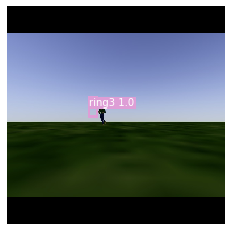

(1) Image
	+ Label: ring3, Conf: 0.98817
	+ Label: ring3, Conf: 0.98974
	+ Label: ring3, Conf: 0.99640


<Figure size 432x288 with 0 Axes>

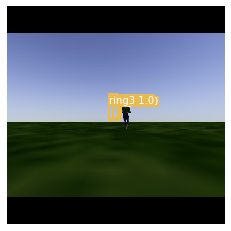

(2) Image
	+ Label: ring3, Conf: 0.99998


<Figure size 432x288 with 0 Axes>

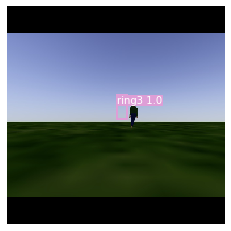

(3) Image
	+ Label: ring3, Conf: 0.99985


<Figure size 432x288 with 0 Axes>

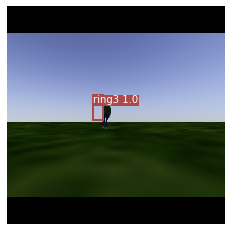

(4) Image
	+ Label: ring3, Conf: 0.99978


<Figure size 432x288 with 0 Axes>

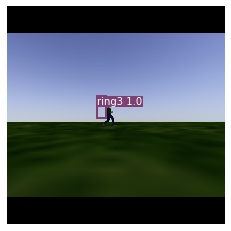

(5) Image
	+ Label: ring3, Conf: 0.99981
	+ Label: ring3, Conf: 0.99973


<Figure size 432x288 with 0 Axes>

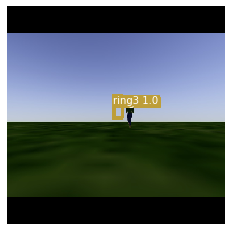

(6) Image
	+ Label: ring1, Conf: 0.90228


<Figure size 432x288 with 0 Axes>

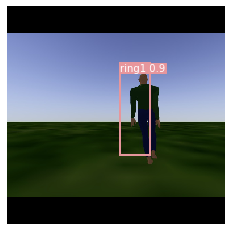

(7) Image
	+ Label: ring2, Conf: 0.97890
	+ Label: ring2, Conf: 0.97075


<Figure size 432x288 with 0 Axes>

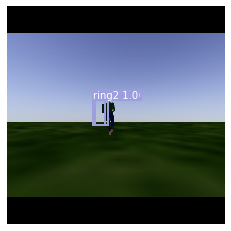

(0) Image
	+ Label: ring3, Conf: 0.83358
	+ Label: ring3, Conf: 0.69902


<Figure size 432x288 with 0 Axes>

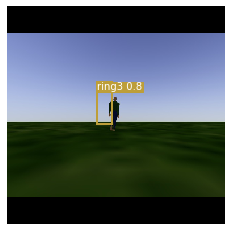

(1) Image
	+ Label: ring3, Conf: 0.99992
	+ Label: ring3, Conf: 0.99993
	+ Label: ring3, Conf: 0.99987


<Figure size 432x288 with 0 Axes>

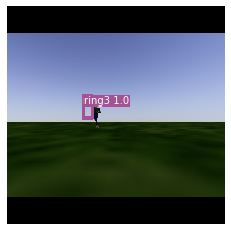

(2) Image
	+ Label: ring1, Conf: 0.94424
	+ Label: ring1, Conf: 0.86839


<Figure size 432x288 with 0 Axes>

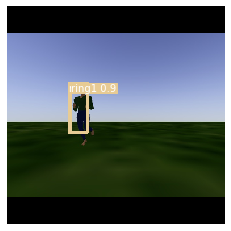

(3) Image


<Figure size 432x288 with 0 Axes>

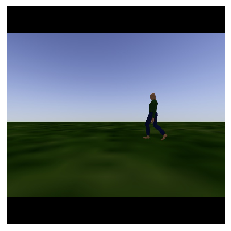

(4) Image
	+ Label: ring3, Conf: 0.99998
	+ Label: ring3, Conf: 0.99998


<Figure size 432x288 with 0 Axes>

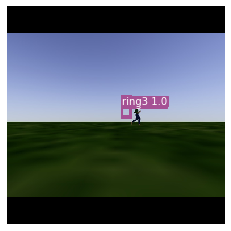

(5) Image


<Figure size 432x288 with 0 Axes>

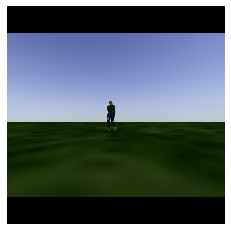

(6) Image
	+ Label: ring3, Conf: 0.99994
	+ Label: ring3, Conf: 0.99994


<Figure size 432x288 with 0 Axes>

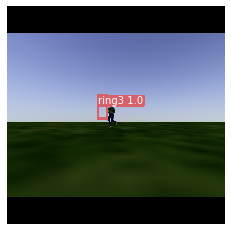

(7) Image
	+ Label: ring3, Conf: 0.99400
	+ Label: ring3, Conf: 0.99531


<Figure size 432x288 with 0 Axes>

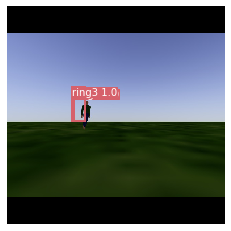

(0) Image
	+ Label: ring3, Conf: 0.99857


<Figure size 432x288 with 0 Axes>

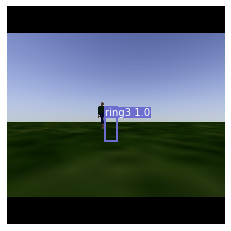

(1) Image
	+ Label: ring3, Conf: 0.98026


<Figure size 432x288 with 0 Axes>

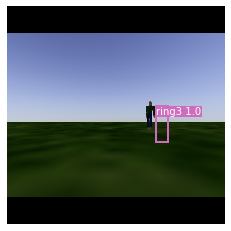

(2) Image


<Figure size 432x288 with 0 Axes>

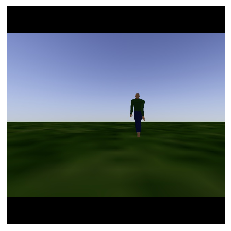

(3) Image
	+ Label: ring1, Conf: 0.91348
	+ Label: ring1, Conf: 0.92010


<Figure size 432x288 with 0 Axes>

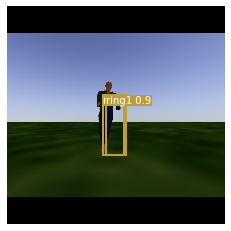

(4) Image
	+ Label: ring1, Conf: 0.99085


<Figure size 432x288 with 0 Axes>

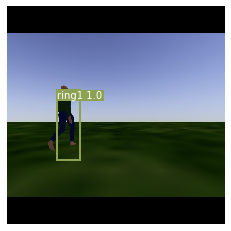

(5) Image
	+ Label: ring3, Conf: 0.99806
	+ Label: ring3, Conf: 0.98712


<Figure size 432x288 with 0 Axes>

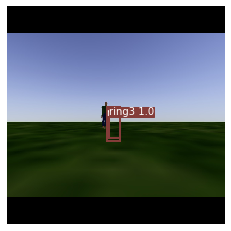

(6) Image
	+ Label: ring3, Conf: 0.99996


<Figure size 432x288 with 0 Axes>

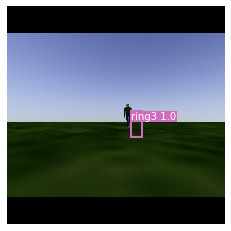

(7) Image
	+ Label: ring1, Conf: 0.98550


<Figure size 432x288 with 0 Axes>

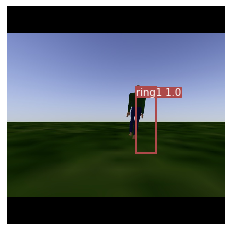

(0) Image
	+ Label: ring2, Conf: 0.97528
	+ Label: ring2, Conf: 0.97464


<Figure size 432x288 with 0 Axes>

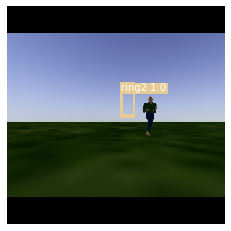

(1) Image
	+ Label: ring1, Conf: 0.93428
	+ Label: ring1, Conf: 0.85525


<Figure size 432x288 with 0 Axes>

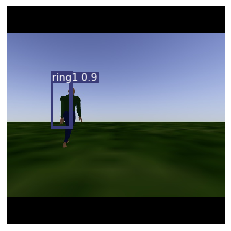

(2) Image
	+ Label: ring3, Conf: 0.99996
	+ Label: ring3, Conf: 0.99997
	+ Label: ring3, Conf: 0.99997


<Figure size 432x288 with 0 Axes>

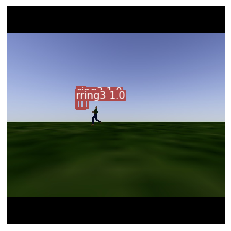

(3) Image
	+ Label: ring3, Conf: 0.99994
	+ Label: ring3, Conf: 0.99996


<Figure size 432x288 with 0 Axes>

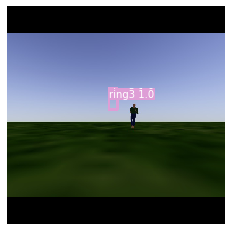

(4) Image
	+ Label: ring3, Conf: 0.99889


<Figure size 432x288 with 0 Axes>

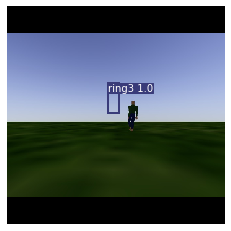

(5) Image
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

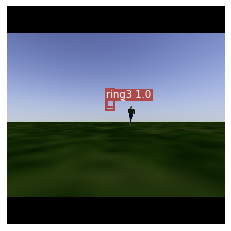

(6) Image
	+ Label: ring2, Conf: 0.88576


<Figure size 432x288 with 0 Axes>

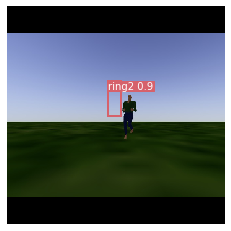

(7) Image
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 0.99996


<Figure size 432x288 with 0 Axes>

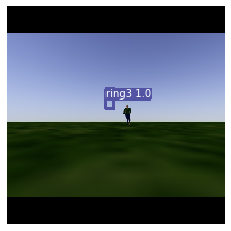

(0) Image
	+ Label: ring2, Conf: 0.95873


<Figure size 432x288 with 0 Axes>

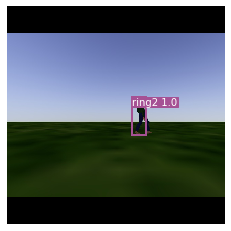

(1) Image
	+ Label: ring1, Conf: 0.90183


<Figure size 432x288 with 0 Axes>

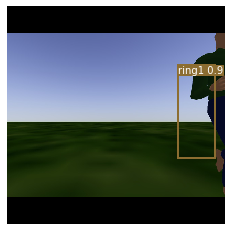

(2) Image
	+ Label: ring3, Conf: 0.99998
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 0.99999


<Figure size 432x288 with 0 Axes>

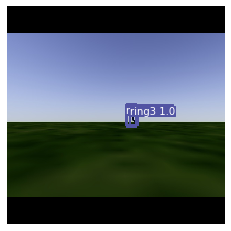

(3) Image
	+ Label: ring3, Conf: 0.99996
	+ Label: ring3, Conf: 0.99994
	+ Label: ring3, Conf: 0.99986


<Figure size 432x288 with 0 Axes>

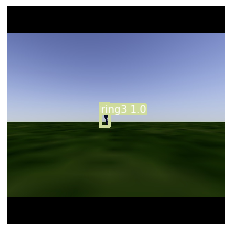

(4) Image
	+ Label: ring2, Conf: 0.95739
	+ Label: ring2, Conf: 0.95627


<Figure size 432x288 with 0 Axes>

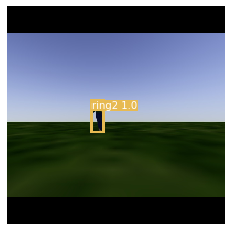

(5) Image
	+ Label: ring2, Conf: 0.72096
	+ Label: ring2, Conf: 0.60256


<Figure size 432x288 with 0 Axes>

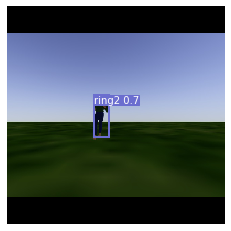

(6) Image
	+ Label: ring3, Conf: 0.99921


<Figure size 432x288 with 0 Axes>

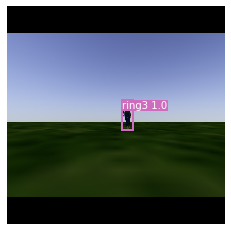

(7) Image
	+ Label: ring3, Conf: 0.78912
	+ Label: ring3, Conf: 0.80942
	+ Label: ring3, Conf: 0.61504


<Figure size 432x288 with 0 Axes>

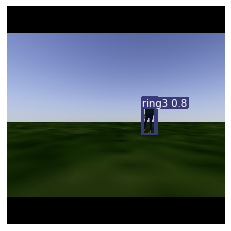

(0) Image


<Figure size 432x288 with 0 Axes>

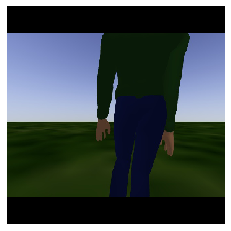

(1) Image
	+ Label: ring2, Conf: 0.94460
	+ Label: ring2, Conf: 0.94197


<Figure size 432x288 with 0 Axes>

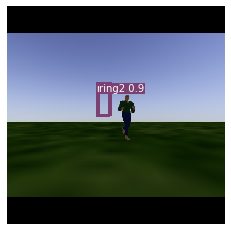

(2) Image
	+ Label: ring1, Conf: 0.88864


<Figure size 432x288 with 0 Axes>

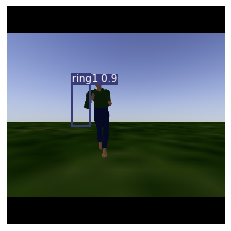

(3) Image
	+ Label: ring2, Conf: 0.89238
	+ Label: ring1, Conf: 0.67951


<Figure size 432x288 with 0 Axes>

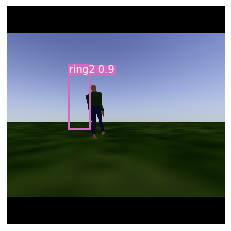

(4) Image
	+ Label: ring3, Conf: 0.75414
	+ Label: ring2, Conf: 0.49888


<Figure size 432x288 with 0 Axes>

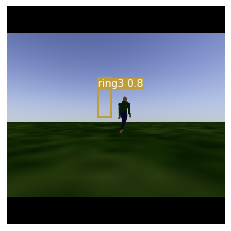

(5) Image


<Figure size 432x288 with 0 Axes>

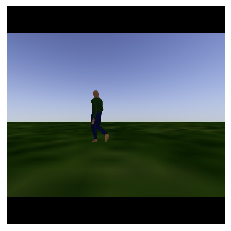

(6) Image
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

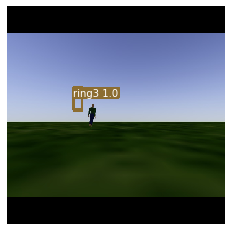

(7) Image
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 0.99998


<Figure size 432x288 with 0 Axes>

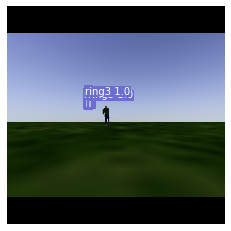

(0) Image
	+ Label: ring3, Conf: 0.99972
	+ Label: ring3, Conf: 0.99947


<Figure size 432x288 with 0 Axes>

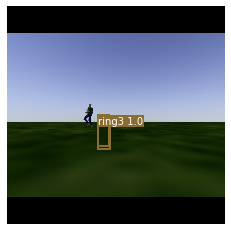

(1) Image
	+ Label: ring2, Conf: 0.95434
	+ Label: ring2, Conf: 0.91788


<Figure size 432x288 with 0 Axes>

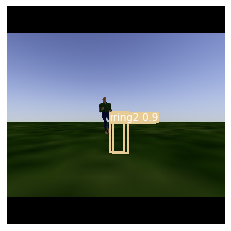

(2) Image
	+ Label: ring3, Conf: 0.88459
	+ Label: ring3, Conf: 0.78391


<Figure size 432x288 with 0 Axes>

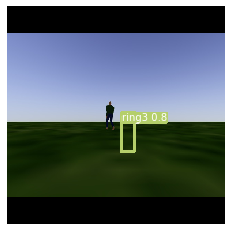

(3) Image
	+ Label: ring3, Conf: 0.90763
	+ Label: ring3, Conf: 0.87529


<Figure size 432x288 with 0 Axes>

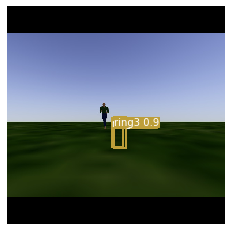

(4) Image
	+ Label: ring3, Conf: 0.99998
	+ Label: ring3, Conf: 0.99996


<Figure size 432x288 with 0 Axes>

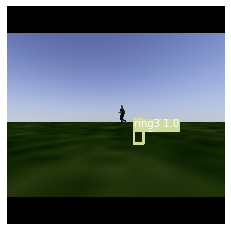

(5) Image
	+ Label: ring1, Conf: 0.95782


<Figure size 432x288 with 0 Axes>

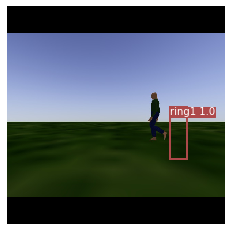

(6) Image
	+ Label: ring3, Conf: 0.86331
	+ Label: ring3, Conf: 0.86067


<Figure size 432x288 with 0 Axes>

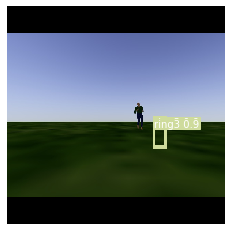

(7) Image
	+ Label: ring3, Conf: 0.99755


<Figure size 432x288 with 0 Axes>

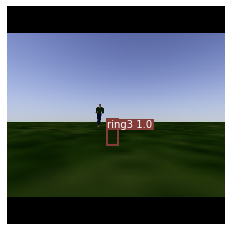

(0) Image
	+ Label: ring3, Conf: 0.99998
	+ Label: ring3, Conf: 0.99997


<Figure size 432x288 with 0 Axes>

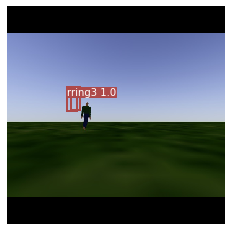

(1) Image
	+ Label: ring2, Conf: 0.97223
	+ Label: ring2, Conf: 0.96851


<Figure size 432x288 with 0 Axes>

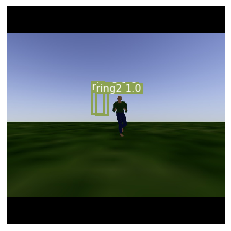

(2) Image
	+ Label: ring3, Conf: 0.99976
	+ Label: ring3, Conf: 0.99985


<Figure size 432x288 with 0 Axes>

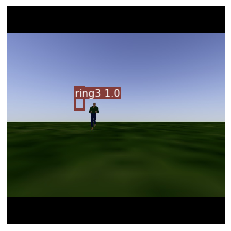

(3) Image
	+ Label: ring3, Conf: 0.99973
	+ Label: ring3, Conf: 0.99955


<Figure size 432x288 with 0 Axes>

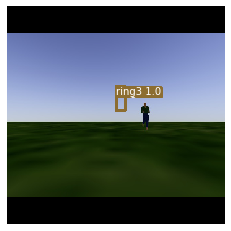

(4) Image
	+ Label: ring3, Conf: 0.68702
	+ Label: ring2, Conf: 0.66597


<Figure size 432x288 with 0 Axes>

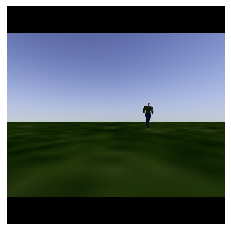

(5) Image
	+ Label: ring1, Conf: 0.72957


<Figure size 432x288 with 0 Axes>

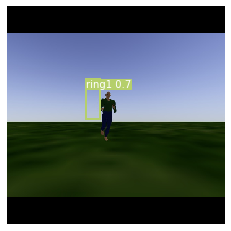

(6) Image
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

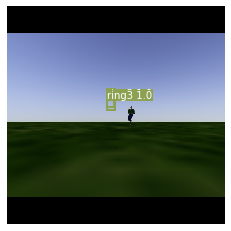

(7) Image
	+ Label: ring3, Conf: 0.99996
	+ Label: ring3, Conf: 0.99990


<Figure size 432x288 with 0 Axes>

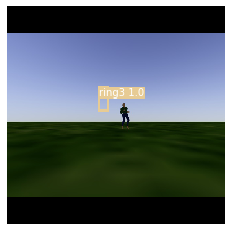

(0) Image


<Figure size 432x288 with 0 Axes>

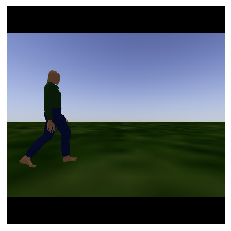

(1) Image
	+ Label: ring3, Conf: 0.99994
	+ Label: ring3, Conf: 0.99987
	+ Label: ring3, Conf: 0.99960


<Figure size 432x288 with 0 Axes>

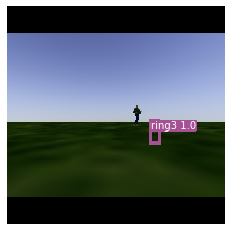

(2) Image
	+ Label: ring3, Conf: 0.99982


<Figure size 432x288 with 0 Axes>

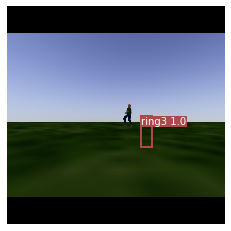

(3) Image
	+ Label: ring1, Conf: 0.98025
	+ Label: ring1, Conf: 0.91586


<Figure size 432x288 with 0 Axes>

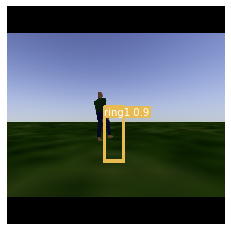

(4) Image
	+ Label: ring3, Conf: 0.60421
	+ Label: ring3, Conf: 0.48557


<Figure size 432x288 with 0 Axes>

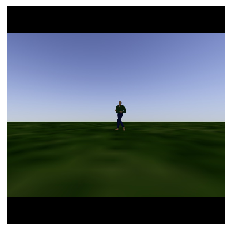

(5) Image


<Figure size 432x288 with 0 Axes>

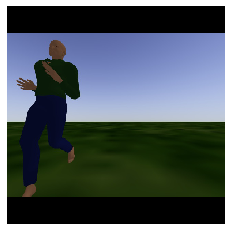

(6) Image
	+ Label: ring3, Conf: 0.99994
	+ Label: ring3, Conf: 0.99998


<Figure size 432x288 with 0 Axes>

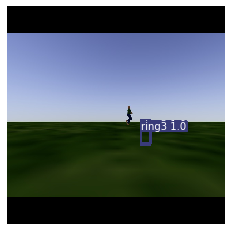

(7) Image
	+ Label: ring3, Conf: 0.99945
	+ Label: ring3, Conf: 0.99928
	+ Label: ring3, Conf: 0.99651
	+ Label: ring3, Conf: 0.99874


<Figure size 432x288 with 0 Axes>

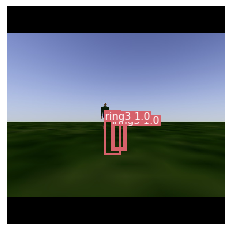

(0) Image


<Figure size 432x288 with 0 Axes>

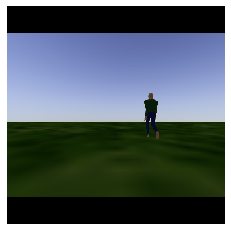

(1) Image
	+ Label: ring2, Conf: 0.89415
	+ Label: ring2, Conf: 0.75718


<Figure size 432x288 with 0 Axes>

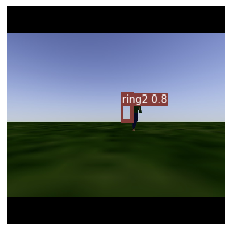

(2) Image


<Figure size 432x288 with 0 Axes>

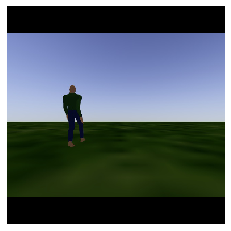

(3) Image


<Figure size 432x288 with 0 Axes>

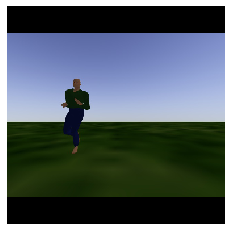

(4) Image


<Figure size 432x288 with 0 Axes>

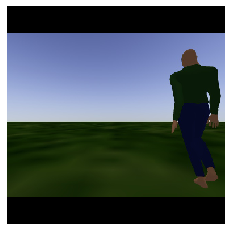

(5) Image
	+ Label: ring3, Conf: 0.99993
	+ Label: ring3, Conf: 0.99985


<Figure size 432x288 with 0 Axes>

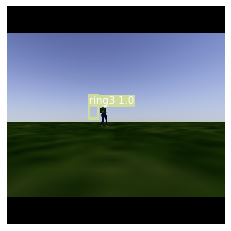

(6) Image
	+ Label: ring2, Conf: 0.93677


<Figure size 432x288 with 0 Axes>

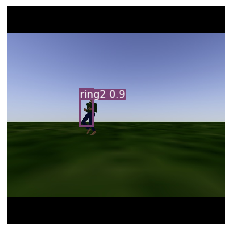

(7) Image
	+ Label: ring2, Conf: 0.96033


<Figure size 432x288 with 0 Axes>

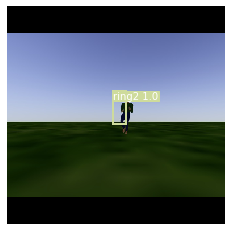

In [15]:
for j in range(10):
    plot_results(j)